In [1]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit


In [20]:
# Load the data
data = pd.read_csv('Data.csv')
data.head()

,date,premise_code,price,premise_type,state
0,2022-01-01,3,6.65,Pasar Raya / Supermarket,Melaka
1,2022-01-03,3,6.65,Pasar Raya / Supermarket,Melaka
2,2022-01-10,3,6.65,Pasar Raya / Supermarket,Melaka
3,2022-02-14,3,6.65,Pasar Raya / Supermarket,Melaka
4,2022-02-21,3,6.65,Pasar Raya / Supermarket,Melaka


In [21]:
# Ensure the date column is in datetime format
data['date'] = pd.to_datetime(data['date'])

In [22]:
# Filter for Perlis state
perlis_data = data[data['state'] == 'Perlis']
perlis_data

,date,premise_code,price,premise_type,state
421,2022-01-01,16,6.7,Pasar Raya / Supermarket,Perlis
422,2022-01-03,16,6.7,Pasar Raya / Supermarket,Perlis
423,2022-01-10,16,6.7,Pasar Raya / Supermarket,Perlis
424,2022-01-17,16,6.7,Pasar Raya / Supermarket,Perlis
425,2022-01-24,16,6.7,Pasar Raya / Supermarket,Perlis
...,...,...,...,...,...
183541,2023-08-26,20890,6.9,Pasar Raya / Supermarket,Perlis
183542,2023-08-27,20890,6.9,Pasar Raya / Supermarket,Perlis
183543,2023-08-28,20890,6.9,Pasar Raya / Supermarket,Perlis
183544,2023-08-29,20890,6.9,Pasar Raya / Supermarket,Perlis


In [23]:
# Data summary
perlis_summary = perlis_data.describe(include='all')
perlis_info = perlis_data.info()

# Checking for missing values
perlis_missing_values = perlis_data.isnull().sum()

perlis_summary, perlis_info, perlis_missing_values

<class 'pandas.core.frame.DataFrame'>
Index: 3353 entries, 421 to 183545
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          3353 non-null   datetime64[ns]
 1   premise_code  3353 non-null   int64         
 2   price         3353 non-null   float64       
 3   premise_type  3353 non-null   object        
 4   state         3353 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 157.2+ KB


(                                 date  premise_code        price  \
 count                            3353    3353.00000  3353.000000   
 unique                            NaN           NaN          NaN   
 top                               NaN           NaN          NaN   
 freq                              NaN           NaN          NaN   
 mean    2023-03-23 23:13:11.291380992   11131.77125     6.913191   
 min               2022-01-01 00:00:00      16.00000     6.500000   
 25%               2022-11-16 00:00:00    1766.00000     6.700000   
 50%               2023-03-31 00:00:00   12691.00000     6.900000   
 75%               2023-08-03 00:00:00   17563.00000     6.900000   
 max               2023-12-31 00:00:00   20890.00000     9.900000   
 std                               NaN    6748.71702     0.395399   
 
                     premise_type   state  
 count                       3353    3353  
 unique                         4       1  
 top     Pasar Raya / Supermarket  Per

In [24]:
# Aggregate the data: average price per day
aggregated_data = perlis_data.groupby('date')['price'].mean().reset_index()
aggregated_data = aggregated_data.sort_values('date')

# Set date as index
aggregated_data.set_index('date', inplace=True)

# Generate a full date range
full_date_range = pd.date_range(start=aggregated_data.index.min(), end=aggregated_data.index.max(), freq='D')

# Reindex the data to this full date range
aggregated_data = aggregated_data.reindex(full_date_range)

# Check for missing values before filling
print("Missing values before filling:")
print(aggregated_data.isnull().sum())

# Fill missing prices
aggregated_data['price'] = aggregated_data['price'].ffill().bfill()

# Reset index to have date as a column again
aggregated_data.reset_index(inplace=True)
aggregated_data.rename(columns={'index': 'date'}, inplace=True)

# Ensure there are no missing values
assert aggregated_data.isnull().sum().sum() == 0

# Check for missing values after filling
print("Missing values after filling:")
print(aggregated_data.isnull().sum())
aggregated_data

Missing values before filling:
price    230
dtype: int64
Missing values after filling:
date     0
price    0
dtype: int64


,date,price
0,2022-01-01,6.671429
1,2022-01-02,6.671429
2,2022-01-03,6.671429
3,2022-01-04,6.671429
4,2022-01-05,6.671429
...,...,...
725,2023-12-27,6.820000
726,2023-12-28,6.810000
727,2023-12-29,6.810000
728,2023-12-30,6.820000


In [9]:
aggregated_data.describe()

,date,price
count,730,730.000000
mean,2022-12-31 12:00:00,6.886144
min,2022-01-01 00:00:00,6.616667
25%,2022-07-02 06:00:00,6.700000
50%,2022-12-31 12:00:00,6.785714
75%,2023-07-01 18:00:00,6.820000
max,2023-12-31 00:00:00,9.900000
std,NaN,0.392041


In [10]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    730 non-null    datetime64[ns]
 1   price   730 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB


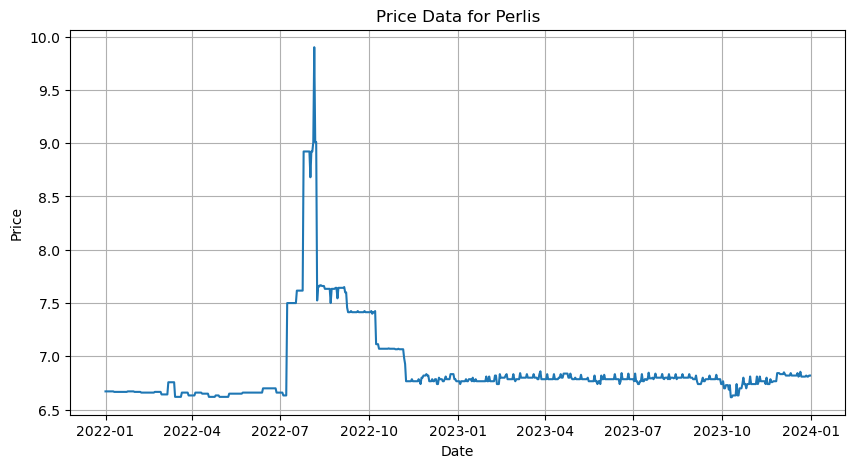

In [11]:
# Plot the data to visually inspect for anomalies
plt.figure(figsize=(10, 5))
plt.plot(aggregated_data['date'], aggregated_data['price'])
plt.title('Price Data for Perlis')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [12]:
# Define the dependent variable
perlis = aggregated_data['price']

# Ensure the indices are datetime indices
perlis.index = pd.to_datetime(aggregated_data['date'])

# Split the data into training and testing sets
train_size = int(len(perlis) * 0.8)
y_train, y_test = perlis.iloc[:train_size], perlis.iloc[train_size:]

# Find the optimal SARIMA parameters using auto_arima
stepwise_model = auto_arima(y_train, 
                            start_p=1, start_q=1,
                            max_p=3, max_q=3, 
                            m=12,  # Seasonal period
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-418.053, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-634.913, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-438.653, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-726.014, Time=1.18 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-713.259, Time=0.64 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-741.687, Time=1.53 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-652.252, Time=0.85 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=9.29 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.90 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-750.615, Time=2.41 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-657.7

In [13]:
# Train the SARIMA model with the optimal parameters
sarima_model = SARIMAX(y_train, 
                       order=stepwise_model.order, 
                       seasonal_order=stepwise_model.seasonal_order)
sarima_fit = sarima_model.fit(disp=False)

C:\Users\afrin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\afrin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\afrin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Make predictions on the training data
y_pred_train = sarima_fit.predict(start=y_train.index[0], end=y_train.index[-1], dynamic=False)
y_pred_train = pd.Series(y_pred_train, index=y_train.index)

# Make predictions on the testing data
y_pred_test = sarima_fit.get_prediction(start=y_test.index[0], end=y_test.index[-1], dynamic=False).predicted_mean
y_pred_test = pd.Series(y_pred_test, index=y_test.index)

# Calculate error metrics for the training data
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mape = mean_absolute_percentage_error(y_train, y_pred_train)

# Calculate error metrics for the testing data
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

In [15]:
# Print the error metrics
print(f'Training MAE: {train_mae}')
print(f'Training RMSE: {train_rmse}')
print(f'Training MAPE: {train_mape}%')

print(f'Testing MAE: {test_mae}')
print(f'Testing RMSE: {test_rmse}')
print(f'Testing MAPE: {test_mape}%')

Training MAE: 0.06025641821164465
Training RMSE: 0.3292963558719701
Training MAPE: 0.8363428931181925%
Testing MAE: 0.20148374497200017
Testing RMSE: 0.22143933297918517
Testing MAPE: 2.9779999592808992%


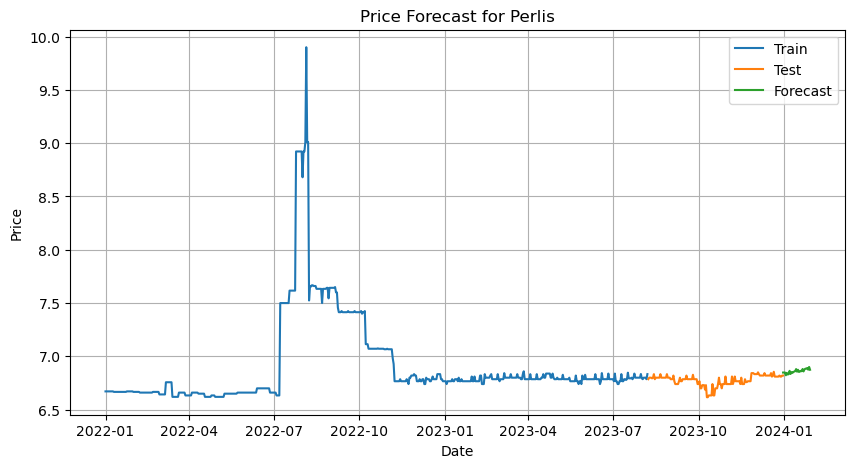

In [16]:
# Forecasting future values
forecast_steps = 30  # Forecast next 30 days
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Align forecast index with test data index
forecast_index = pd.date_range(start=y_test.index[-1], periods=forecast_steps, freq='D')
forecast_mean.index = forecast_index

# Plotting the forecast
plt.figure(figsize=(10, 5))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.legend()
plt.title('Price Forecast for Perlis')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

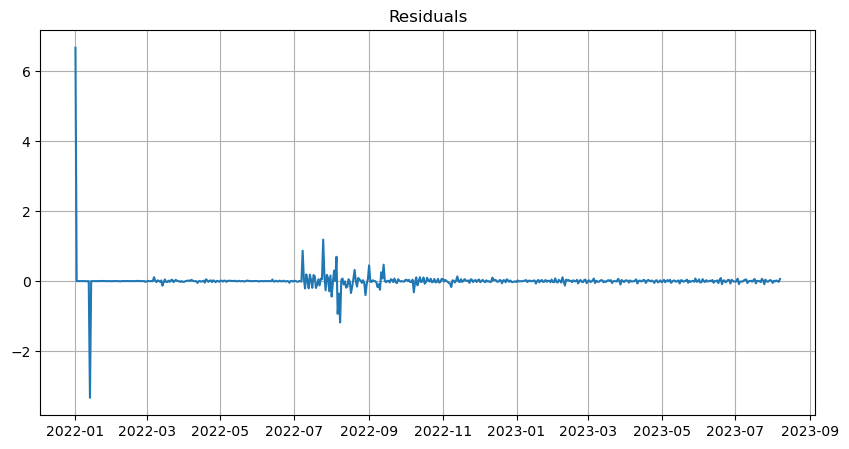

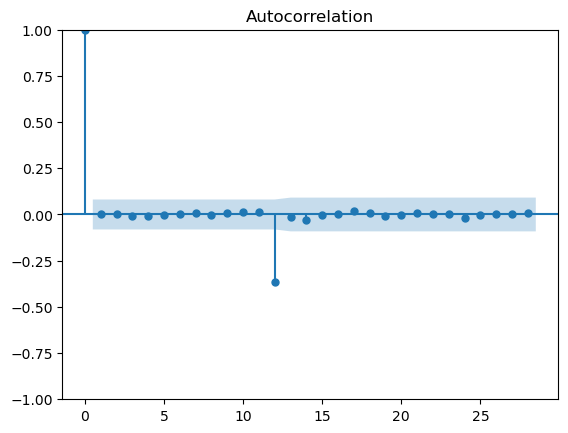

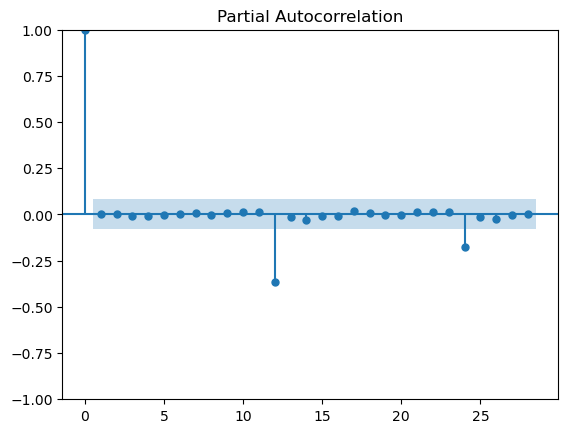

In [17]:
# Residual Analysis
residuals = sarima_fit.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals')
plt.grid(True)
plt.show()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals)
plt.show()
plot_pacf(residuals)
plt.show()


Indices with NaN values after log transformation: Index([], dtype='int64')
Any NaN values after interpolation: False


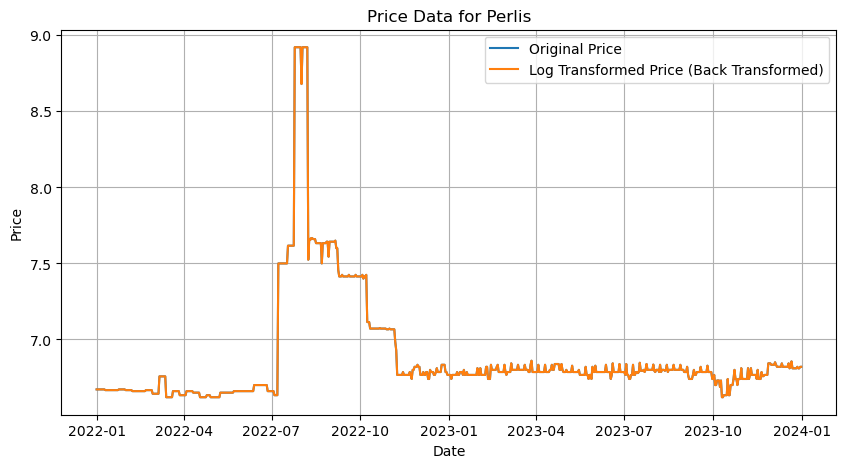

In [25]:
# Handle outliers by capping values at the 1st and 99th percentiles
lower_bound = aggregated_data['price'].quantile(0.01)
upper_bound = aggregated_data['price'].quantile(0.99)
aggregated_data['price'] = np.clip(aggregated_data['price'], lower_bound, upper_bound)

# Add a small constant to avoid log of zero
aggregated_data['price'] += 1e-5

# Log transform the price data
aggregated_data['log_price'] = np.log(aggregated_data['price'])

# Identify NaN values in log-transformed data
nan_indices = aggregated_data[aggregated_data['log_price'].isna()].index
print("Indices with NaN values after log transformation:", nan_indices)

# Fill NaN values using interpolation
aggregated_data['log_price'] = aggregated_data['log_price'].interpolate(method='linear')

# Ensure no NaN values remain
print("Any NaN values after interpolation:", aggregated_data['log_price'].isnull().any())

# Plot the data to visually inspect for anomalies
plt.figure(figsize=(10, 5))
plt.plot(aggregated_data['date'], aggregated_data['price'], label='Original Price')
plt.plot(aggregated_data['date'], np.exp(aggregated_data['log_price']) - 1e-5, label='Log Transformed Price (Back Transformed)')
plt.title('Price Data for Perlis')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Define the dependent variable
perlis_log = aggregated_data['log_price']

# Ensure the indices are datetime indices
perlis_log.index = pd.to_datetime(aggregated_data['date'])

# Split the data into training and testing sets
train_size = int(len(perlis_log) * 0.8)
y_train_log, y_test_log = perlis_log.iloc[:train_size], perlis_log.iloc[train_size:]

# Find the optimal SARIMA parameters using auto_arima
stepwise_model_log = auto_arima(y_train_log, 
                                start_p=1, start_q=1,
                                max_p=3, max_q=3, 
                                m=12,  # Seasonal period
                                start_P=0, seasonal=True,
                                d=1, D=1, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

print(stepwise_model_log.summary())

# Train the SARIMA model with the optimal parameters
sarima_model_log = SARIMAX(y_train_log, 
                           order=stepwise_model_log.order, 
                           seasonal_order=stepwise_model_log.seasonal_order)
sarima_fit_log = sarima_model_log.fit(disp=False)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3046.958, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3194.395, Time=1.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.28 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3046.762, Time=0.19 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3268.390, Time=4.46 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.67 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.27 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3267.414, Time=0.79 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-3266.924, Time=2.90 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3266.679, Time=1.48 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3268.208, Time=1.39 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-3264.932, Time=3.40 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=-3266.386, Time=2.52 sec

Best model:  ARIMA(1,1,0)(2,

C:\Users\afrin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\afrin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [27]:
# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Make predictions on the training data
y_pred_train_log = sarima_fit_log.predict(start=y_train_log.index[0], end=y_train_log.index[-1], dynamic=False)
y_pred_train_log = pd.Series(y_pred_train_log, index=y_train_log.index)

# Make predictions on the testing data
y_pred_test_log = sarima_fit_log.get_prediction(start=y_test_log.index[0], end=y_test_log.index[-1], dynamic=False).predicted_mean
y_pred_test_log = pd.Series(y_pred_test_log, index=y_test_log.index)

# Inverse transform the predictions
y_pred_train = np.exp(y_pred_train_log) - 1e-5
y_pred_test = np.exp(y_pred_test_log) - 1e-5

# Calculate error metrics for the training data
train_mae = mean_absolute_error(np.exp(y_train_log) - 1e-5, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(np.exp(y_train_log) - 1e-5, y_pred_train))
train_mape = mean_absolute_percentage_error(np.exp(y_train_log) - 1e-5, y_pred_train)

# Calculate error metrics for the testing data
test_mae = mean_absolute_error(np.exp(y_test_log) - 1e-5, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(np.exp(y_test_log) - 1e-5, y_pred_test))
test_mape = mean_absolute_percentage_error(np.exp(y_test_log) - 1e-5, y_pred_test)

# Print the error metrics
print(f'Training MAE: {train_mae}')
print(f'Training RMSE: {train_rmse}')
print(f'Training MAPE: {train_mape}%')

print(f'Testing MAE: {test_mae}')
print(f'Testing RMSE: {test_rmse}')
print(f'Testing MAPE: {test_mape}%')

Training MAE: 0.05880256850701702
Training RMSE: 0.5070804717002918
Training MAPE: 0.8392267478871281%
Testing MAE: 0.19115664773404625
Testing RMSE: 0.2106034067919722
Testing MAPE: 2.8255602104253366%


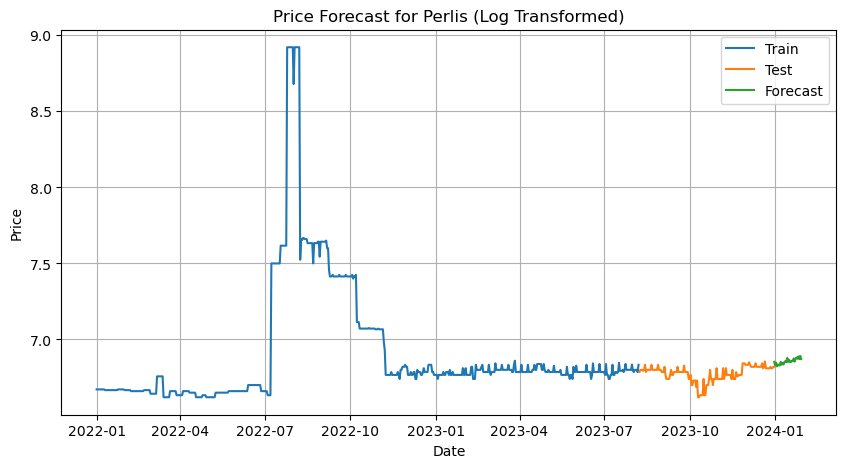

In [28]:
# Forecasting future values
forecast_steps = 30  # Forecast next 30 days
forecast_log = sarima_fit_log.get_forecast(steps=forecast_steps)
forecast_mean_log = forecast_log.predicted_mean

# Inverse transform the forecast
forecast_mean = np.exp(forecast_mean_log) - 1e-5

# Align forecast index with test data index
forecast_index = pd.date_range(start=y_test_log.index[-1], periods=forecast_steps, freq='D')
forecast_mean.index = forecast_index

# Plotting the forecast
plt.figure(figsize=(10, 5))
plt.plot(np.exp(y_train_log).index, np.exp(y_train_log) - 1e-5, label='Train')
plt.plot(np.exp(y_test_log).index, np.exp(y_test_log) - 1e-5, label='Test')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.legend()
plt.title('Price Forecast for Perlis (Log Transformed)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

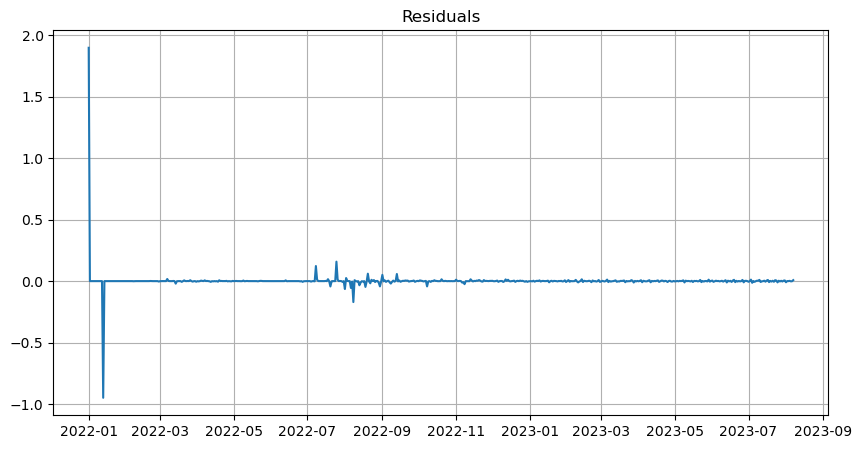

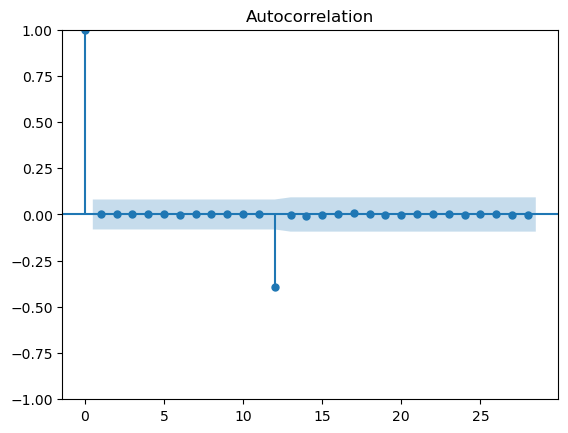

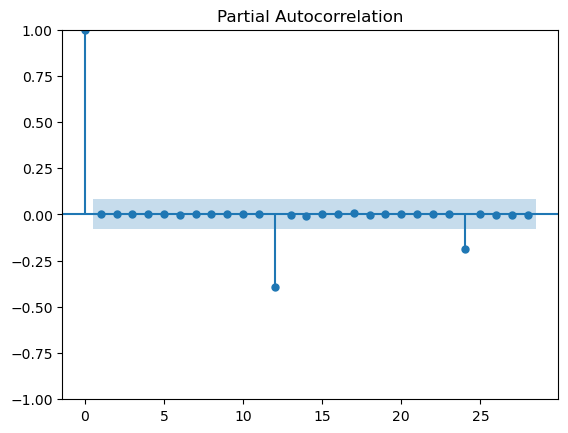

In [29]:
# Residual Analysis
residuals_log = sarima_fit_log.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals_log)
plt.title('Residuals')
plt.grid(True)
plt.show()

plot_acf(residuals_log)
plt.show()
plot_pacf(residuals_log)
plt.show()

### CROSS VALIDATION

In [30]:
# Cross-validation function

def rolling_forecast_cv(data, n_splits, model_order, seasonal_order):
    """
    Perform rolling forecast cross-validation on time series data.
    
    Parameters:
    - data: pd.Series, the time series data
    - n_splits: int, the number of splits
    - model_order: tuple, the (p,d,q) order of the SARIMA model
    - seasonal_order: tuple, the (P,D,Q,m) seasonal order of the SARIMA model
    
    Returns:
    - A tuple of lists containing MAE, RMSE, and MAPE for each split
    """
    mae_list = []
    rmse_list = []
    mape_list = []

    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]

        model = SARIMAX(train, order=model_order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        
        predictions = model_fit.predict(start=test.index[0], end=test.index[-1])
        
        mae = mean_absolute_error(test, predictions)
        rmse = np.sqrt(mean_squared_error(test, predictions))
        mape = np.mean(np.abs((test - predictions) / test)) * 100
        
        mae_list.append(mae)
        rmse_list.append(rmse)
        mape_list.append(mape)
    
    return mae_list, rmse_list, mape_list


In [31]:
# Find the optimal SARIMA parameters using auto_arima
stepwise_model_log = auto_arima(perlis_log, 
                                start_p=1, start_q=1,
                                max_p=3, max_q=3, 
                                m=12,  # Seasonal period
                                start_P=0, seasonal=True,
                                d=1, D=1, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

print(stepwise_model_log.summary())

# Extract model parameters
model_order = stepwise_model_log.order
seasonal_order = stepwise_model_log.seasonal_order


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.87 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3960.514, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4153.200, Time=0.69 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.78 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3961.461, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-4243.239, Time=2.61 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.71 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.01 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-4239.707, Time=0.90 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-4241.641, Time=3.07 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-4241.461, Time=1.59 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-4242.960, Time=2.34 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-4239.676, Time=3.98 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=-4241.238, Time=8.80 sec

Best model:  ARIMA(1,1,0)(2,

In [32]:
# Perform cross-validation
n_splits = 5
mae_list, rmse_list, mape_list = rolling_forecast_cv(perlis_log, n_splits, model_order, seasonal_order)

# Print results
print("Cross-Validation Results:")
print("MAE:", mae_list)
print("RMSE:", rmse_list)
print("MAPE:", mape_list)
print("Average MAE:", np.mean(mae_list))
print("Average RMSE:", np.mean(rmse_list))
print("Average MAPE:", np.mean(mape_list))


C:\Users\afrin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\afrin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\afrin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\afrin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\afrin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

Cross-Validation Results:
MAE: [0.09272247556430871, 0.084993520486942, 0.014988189824370328, 0.0072369148573117196, 0.007210221024756028]
RMSE: [0.13601064966172405, 0.099684900650307, 0.01754834376976754, 0.008897566770664368, 0.009229862424186226]
MAPE: [4.46108519589747, 4.396806027054364, 0.7817098813669402, 0.37747303215989386, 0.3774785743841195]
Average MAE: 0.04143026435153776
Average RMSE: 0.05427426465532984
Average MAPE: 2.0789105421725576


### MODEL VALIDATION

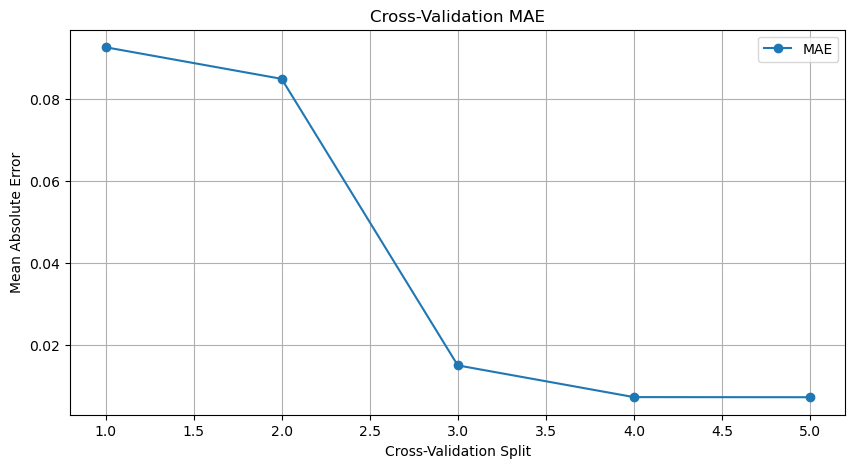

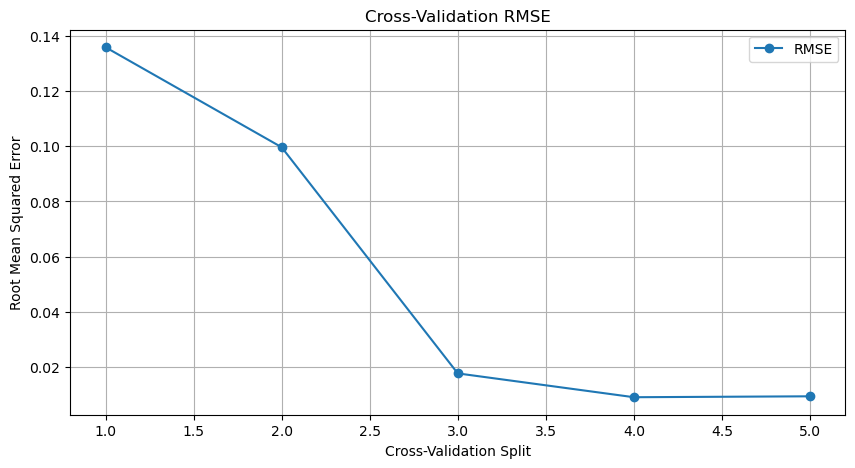

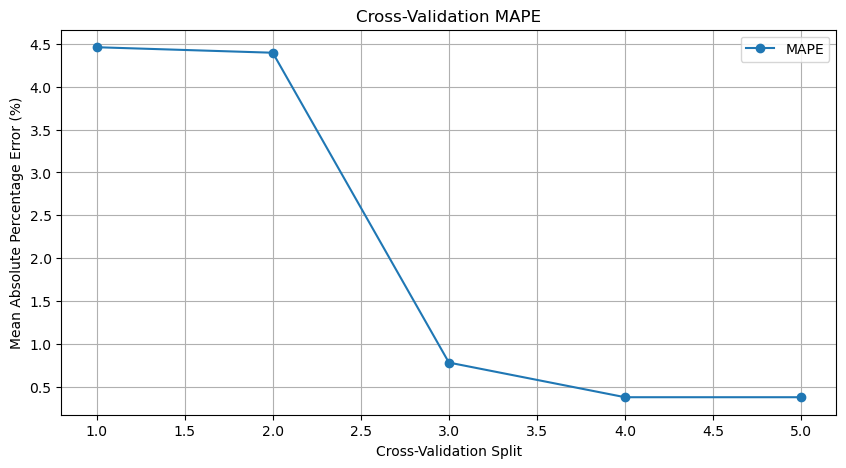

In [33]:
# Plot MAE
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_splits + 1), mae_list, marker='o', label='MAE')
plt.xlabel('Cross-Validation Split')
plt.ylabel('Mean Absolute Error')
plt.title('Cross-Validation MAE')
plt.grid(True)
plt.legend()
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_splits + 1), rmse_list, marker='o', label='RMSE')
plt.xlabel('Cross-Validation Split')
plt.ylabel('Root Mean Squared Error')
plt.title('Cross-Validation RMSE')
plt.grid(True)
plt.legend()
plt.show()

# Plot MAPE
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_splits + 1), mape_list, marker='o', label='MAPE')
plt.xlabel('Cross-Validation Split')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.title('Cross-Validation MAPE')
plt.grid(True)
plt.legend()
plt.show()


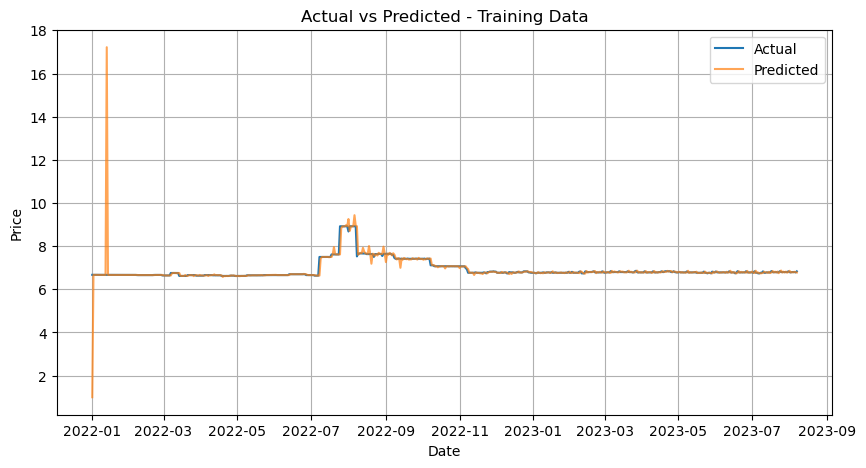

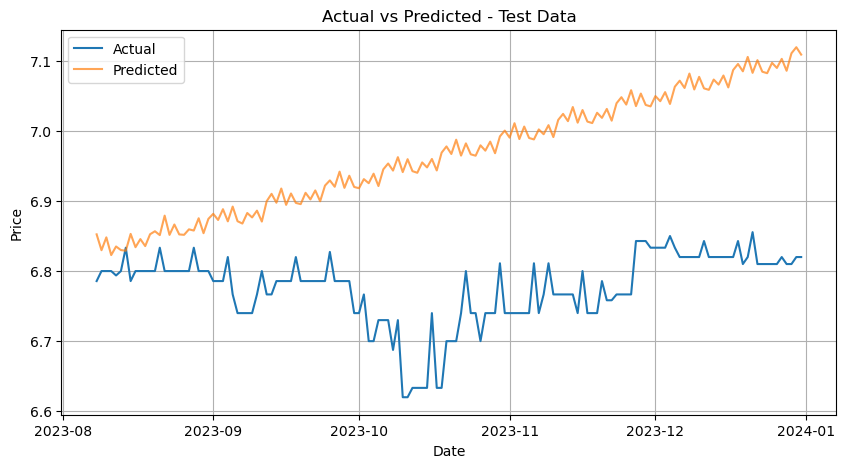

In [34]:
# Actual vs Predicted Plot for Training Data
plt.figure(figsize=(10, 5))
plt.plot(y_train_log.index, np.exp(y_train_log) - 1e-5, label='Actual')
plt.plot(y_train_log.index, y_pred_train, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted - Training Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Actual vs Predicted Plot for Test Data
plt.figure(figsize=(10, 5))
plt.plot(y_test_log.index, np.exp(y_test_log) - 1e-5, label='Actual')
plt.plot(y_test_log.index, y_pred_test, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted - Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


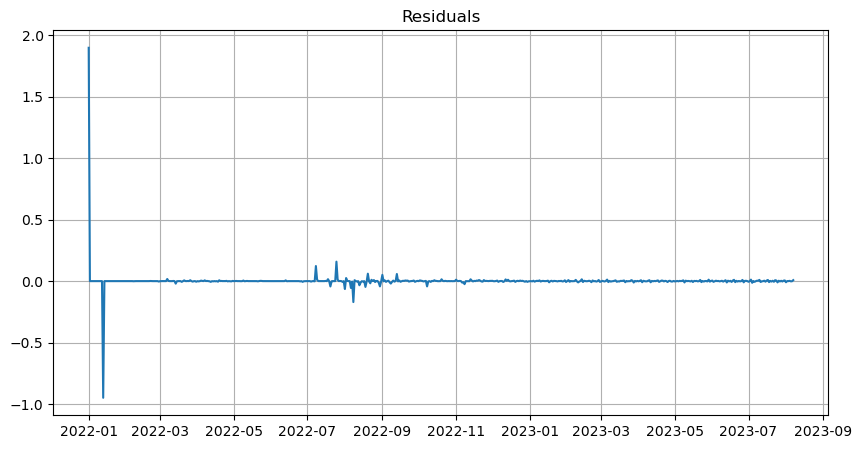

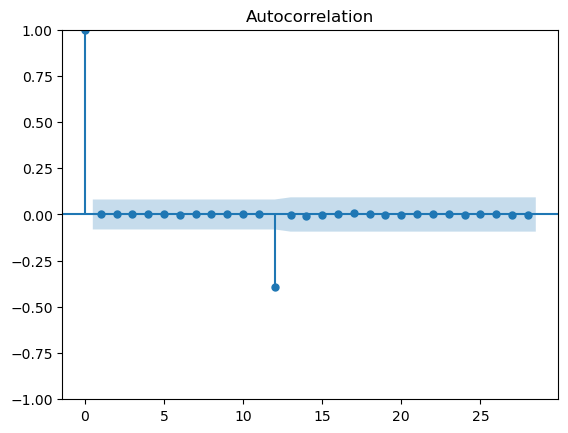

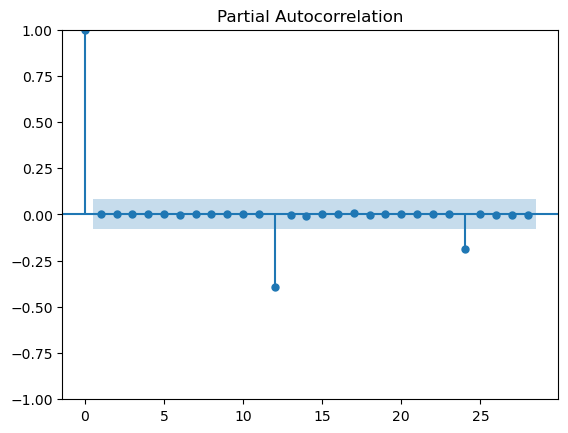

In [35]:
# Plot Residuals
residuals_log = sarima_fit_log.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals_log)
plt.title('Residuals')
plt.grid(True)
plt.show()

# Autocorrelation of Residuals
plot_acf(residuals_log)
plt.show()
plot_pacf(residuals_log)
plt.show()


In [36]:
import csv

# Save metrics to a CSV file
metrics = {
    'Training MAE': train_mae,
    'Training RMSE': train_rmse,
    'Training MAPE': train_mape,
    'Testing MAE': test_mae,
    'Testing RMSE': test_rmse,
    'Testing MAPE': test_mape
}

with open('PERLIS_metrics.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Metric', 'Value'])
    for key, value in metrics.items():
        writer.writerow([key, value])

# Save cross-validation results to a CSV file
cv_results = {
    'MAE': mae_list,
    'RMSE': rmse_list,
    'MAPE': mape_list
}

with open('PERLIS_cv_results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Split', 'MAE', 'RMSE', 'MAPE'])
    for i in range(n_splits):
        writer.writerow([i+1, mae_list[i], rmse_list[i], mape_list[i]])


In [37]:
# Combine train, test, and forecast data
results = pd.DataFrame({
    'date': aggregated_data['date'],
    'original': np.exp(perlis_log) - 1e-5,
    'train': pd.Series(np.exp(y_train_log) - 1e-5, index=y_train_log.index),
    'test': pd.Series(np.exp(y_test_log) - 1e-5, index=y_test_log.index),
    'forecast': pd.Series(forecast_mean, index=forecast_index)
})

# Ensure all columns align with the date index
results.set_index('date', inplace=True)

# Fill NaN values where necessary
results['train'].fillna('', inplace=True)
results['test'].fillna('', inplace=True)
results['forecast'].fillna('', inplace=True)

# Reset index to have date as a column again
results.reset_index(inplace=True)

# Save to CSV
results.to_csv('PERLIS.csv', index=False)